In [ ]:
!pip install keras-self-attention --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [ ]:
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
import keras

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, Concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model, load_model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler

from keras_self_attention import SeqSelfAttention
from keras.utils.vis_utils import plot_model

In [ ]:
filename = "/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr8k.token.txt" # Absolute path of the caption 
file = open(filename,'r')
doc = file.read() # This will contain the Caption of the each image in a textual format
print(doc[:400])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wood


In [ ]:
# Loading the Caption with the Image name as a id to the dictionary : dict[image_name] = captions

descriptions =dict()
for line in doc.split('\n'):# splitting the doc using newline

  if len(line)<2:
    continue
  tokens =  line.split() #splitting the line by white spaces

  image_id , image_desc = tokens[0],tokens[1:]
  image_desc = ' '.join(image_desc) # joining the generated words by splitting into again captions

  # image id -> 1000268201_693b08cb0e.jpg#0 we have to split it by dot to get unique name of image
  image_name = image_id.split('.')[0]

  if image_name not in descriptions.keys():
    descriptions[image_name] = list()
  
  descriptions[image_name].append(image_desc)

print(len(descriptions))

8092


In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
table = str.maketrans('','',string.punctuation)

for _, captions in descriptions.items():
  for i in range(len(captions)):

    desc = captions[i].split()

    # removing punctuations
    desc = [c.translate(table) for c in desc]

    # removing non alphabetic characters
    desc = [word for word in desc if word.isalpha()]

    # removing single length words
    desc = [word for word in desc if len(word)>=2]

    # converting all the char into lower 
    desc = [word.lower() for word in desc]

    captions[i] = ' '.join(desc)

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
vocabulary = set()

for key in descriptions:
  for d in descriptions[key]:
    vocabulary.update(d.split())

print('Vocabulary Size :',len(vocabulary))

Vocabulary Size : 8763


In [ ]:
filename1 = "/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr_8k.trainImages.txt" # Captions for training dataset
file = open(filename1,'r')
train_doc = file.read()

training_image_name = list()

for line in train_doc.split('\n'):
  if len(line)<1:
    continue
  
  id = line.split('.')[0]
  training_image_name.append(id)

filename2 = "/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr_8k.devImages.txt" # Captions for training dataset
file = open(filename2,'r')
val_doc = file.read()

for line in val_doc.split('\n'):
  if len(line)<1:
    continue
  
  id = line.split('.')[0]
  training_image_name.append(id)


training_image_name = set(training_image_name)
print('Length of Train Datset:',len(training_image_name))
print(training_image_name)

Length of Train Datset: 7000
{'3495490064_8db40a83af', '3279025792_23bfd21bcc', '3159641529_c2c74f3eaf', '1819261140_6c022f4b1d', '759015118_4bd3617e60', '2377460540_8cfb62463a', '1600208439_e94527b80f', '3468023754_8a07d4c56e', '460781612_6815c74d37', '3604391853_b4809fcb8c', '3426789838_8771f0ed56', '3401039304_424ffc7dbf', '3685372942_6ae935b34e', '2068960566_21e85ae0dc', '2729685399_56c0e104b1', '1691573772_1adef8e40e', '3465473743_7da0c5d973', '3537920947_6c5a956f47', '3048461682_e89f81b1c7', '2076865206_53918c820c', '2121140070_a09644550b', '287999021_998c2eeb91', '3655773435_c234e94820', '465859490_b077219424', '181103691_fb2f956abd', '2189181027_a445b13438', '3665569615_9a71c4b6e4', '1148238960_f8cacec2fc', '262446581_06ef7d9445', '3400041870_4e7732b40f', '3189964753_a95536ced9', '3278777548_290b881018', '2995461857_dd26188dcf', '3636632926_09f39f2629', '3354414391_a3908bd4ff', '3726130458_07df79e969', '2171891283_dedd9cf416', '3627216820_4952bacbcb', '3680031186_c3c6698f9d', '

In [ ]:
images = '/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/'
img = glob.glob(images+'*.jpg')

print(img[0])

/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/416960865_048fd3f294.jpg


In [ ]:
training_image_file  = set(open(filename1, 'r').read().strip().split('\n')) # image_name.jpg

# Create a list of all the training images with their full path names
training_image_full_path = [] # /content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/image_name.jpg

for i in img: # img is list of full path names of all images
    if i[len(images):] in training_image_file: # Check if the image belongs to training set
        training_image_full_path.append(i) # Add it to the list of train images

training_image_file2  = set(open(filename2, 'r').read().strip().split('\n')) # image_name.jpg
for i in img: # img is list of full path names of all images
    if i[len(images):] in training_image_file2: # Check if the image belongs to training set
        training_image_full_path.append(i) # Add it to the list of train images

In [ ]:
print(len(training_image_full_path))
print(training_image_full_path[0])

7000
/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/416650559_cd08d3cd96.jpg


In [ ]:
test_images_file = '/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr_8k.testImages.txt'

test_image_file = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_image_full_path = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_image_file: # Check if the image belongs to test set
        test_image_full_path.append(i) # Add it to the list of test images

In [ ]:
print(len(test_image_full_path))
print(test_image_full_path[0])

1000
/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/416960865_048fd3f294.jpg


In [ ]:
train_desc = dict()

for i in descriptions.keys():
  if i in training_image_name:
    if i not in train_desc:
      train_desc[i] = list()

    for cap in descriptions[i]:
      desc = 'startseq '+cap+' endseq'
      train_desc[i].append(desc)

print(len(train_desc))

7000


In [ ]:
train_desc['2254913901_569f568926']

['startseq louis vuitton store window at night endseq',
 'startseq woman looks at clothes in louis vuitton store window endseq',
 'startseq woman widow shops outside of louis vuitton store endseq',
 'startseq the woman in black is looking at outfits in clothing store window endseq',
 'startseq woman on the street window shops in front of the store louis vuitton endseq']

In [ ]:
model = InceptionV3(weights='imagenet') # loading the inceptionv3 model
new_model = Model (model.input, model.layers[-2].output) # creating a new_model which have same input but second last layer as an output

96124928/96112376 [==============================] - 0s 0us/step


In [ ]:
def preprocess(path):
  img_ = load_img(path,target_size=(299,299)) # reshaping the input images into 299x299 same as inceptionv3
  x_arr = img_to_array(img_) # converting the image into 3d array
  x_arr = np.expand_dims(x_arr,axis=0) # adding a new dimension => (299,299,3) will converted into (1,299,299,3)
  x_arr = preprocess_input(x_arr)

  return x_arr

In [ ]:
def encode(path):
    image = preprocess(path) # preprocess the image
    feat_vec = new_model.predict(image) # Get the encoding vector for the image
    feat_vec = np.reshape(feat_vec, feat_vec.shape[1]) # reshape from (1, 2048) to (2048, )

    return feat_vec

In [ ]:
train_features = load(open("/content/drive/MyDrive/ImageCaptioning/Resources/encoded_train_images_with_val.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=7000


In [ ]:
test_features = load(open("/content/drive/MyDrive/ImageCaptioning/Resources/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [ ]:
all_train_captions = []
for key in train_desc.keys():
    for cap in train_desc[key]:
        all_train_captions.append(cap)
len(all_train_captions)

35000

In [ ]:
str_all_train_captions = str(all_train_captions).replace(',',' ').replace('\'',' ')

In [ ]:
# considering all those words which appear more than or equal to 2 times in our training corpus

word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab_ = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab_)))

preprocessed words 8169 -> 2764


In [ ]:
ixtoword = {} # will give word as an output for an index ( from 1 to 1889)
wordtoix = {} # will give an index as an output for a word

ix = 1
for w in vocab_:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's after padding 
vocab_size

2765

In [ ]:
all_desc = list()
for key in train_desc.keys():
  [all_desc.append(d) for d in train_desc[key]]

max_length = max(len(d.split()) for d in all_desc)
print(max_length)

34


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from gensim.models import Word2Vec

all_sentences = nltk.sent_tokenize(str_all_train_captions)
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

w2v = Word2Vec(all_words)
print(w2v.wv['startseq'].shape)

(100,)


In [ ]:
w2v_vocab = w2v.wv.vocab

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim)) # embedding vector of 100 len for every word in our training vocab

for word, ix in wordtoix.items():
  if str(word) in w2v_vocab:

    embedding_matrix[ix] = w2v.wv[str(word)]

print(embedding_matrix.shape)

(2765, 100)


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
      for key, desc_list in descriptions.items():
          n+=1
          # retrieve the photo feature
          photo = photos[key + '.jpg']
          for desc in desc_list:
              # encode the sequence
              seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
              # split one sequence into multiple X, y pairs
              for i in range(1, len(seq)):
                  # split into input and output pair
                  in_seq, out_seq = seq[:i], seq[i]
                  # pad input sequence
                  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                  # encode output sequence
                  out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                  # store
                  X1.append(photo)
                  X2.append(in_seq)
                  y.append(out_seq)
          # yield the batch data
          if n==num_photos_per_batch:
              yield ([array(X1), array(X2)], array(y))
              X1, X2, y = list(), list(), list()
              n=0


In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [67]:
def beam_search_predictions(image, beam_index):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
            prev = i
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

---
# **Model with Self Attention Module**

In [ ]:
def selfAttentionModel(vocab_size,max_length,embedding_dim):

  image_model = Sequential()
  image_model.add(Dense(512, input_shape=(2048,), activation='relu'))
  image_model.add(Dense(embedding_dim, activation='relu'))
  image_model.add(RepeatVector(max_length))

  language_model = Sequential()
  language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, mask_zero=True))
  language_model.add(LSTM(256, return_sequences=True))
  language_model.add(TimeDistributed(Dense(embedding_dim)))

  conca = Concatenate()([image_model.output, language_model.output])
  x = LSTM(128, return_sequences=True)(conca)
  x = LSTM(512, return_sequences=True)(x)
  x = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       name='Attention')(x)
  x = keras.layers.Flatten()(x)
  x = Dense(vocab_size)(x)
  out = Activation('softmax')(x)
  model = Model(inputs=[image_model.input, language_model.input], outputs = out)

  return model

In [ ]:
model = selfAttentionModel(vocab_size,max_length,embedding_dim)

In [ ]:
print(model.layers)

[<keras.engine.input_layer.InputLayer object at 0x7f7d47757190>, <keras.engine.input_layer.InputLayer object at 0x7f7d47759790>, <keras.layers.core.dense.Dense object at 0x7f7d47737e10>, <keras.layers.embeddings.Embedding object at 0x7f7d477e9450>, <keras.layers.core.dense.Dense object at 0x7f7d49b36150>, <keras.layers.recurrent_v2.LSTM object at 0x7f7d47759150>, <keras.layers.core.repeat_vector.RepeatVector object at 0x7f7d47783950>, <keras.layers.wrappers.TimeDistributed object at 0x7f7d45714410>, <keras.layers.merge.Concatenate object at 0x7f7d455ab750>, <keras.layers.recurrent_v2.LSTM object at 0x7f7d455b4650>, <keras.layers.recurrent_v2.LSTM object at 0x7f7df3b80a10>, <keras_self_attention.seq_self_attention.SeqSelfAttention object at 0x7f7d453c5150>, <keras.layers.core.flatten.Flatten object at 0x7f7d452bbd90>, <keras.layers.core.dense.Dense object at 0x7f7d44f73d90>, <keras.layers.core.activation.Activation object at 0x7f7d44e6bc50>]


In [ ]:
model.layers[3].set_weights([embedding_matrix])
model.layers[3].trainable = False

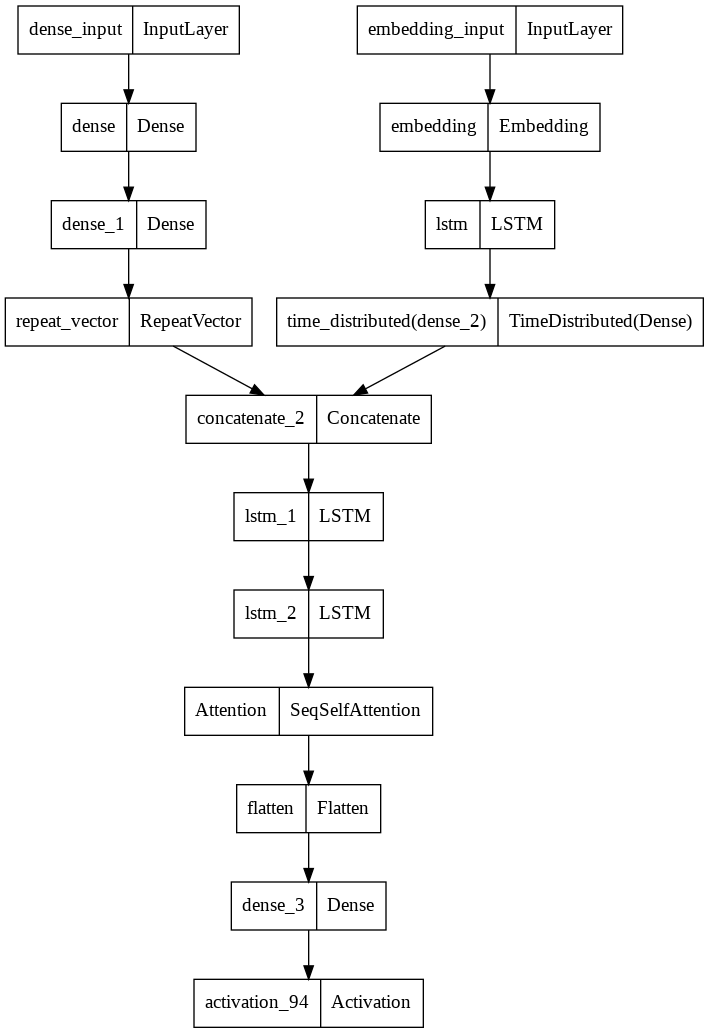

In [ ]:
plot_model(model)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

**Training**

In [ ]:
epochs = 10
number_pics_per_batch = 16
steps = len(train_desc)//number_pics_per_batch

In [ ]:
#First part training
for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_batch)
    history1 = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

437/437 [==============================] - 175s 400ms/step - loss: 3.1239 - accuracy: 0.3016


In [ ]:
model = selfAttentionModel(vocab_size,max_length,embedding_dim)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop',metrics=['accuracy'])
model.load_weights('/content/drive/MyDrive/ImageCaptioning/Resources/sam21.h5')

# model.save_weights('/content/drive/MyDrive/ImageCaptioning/Resources/sam21.h5')

In [48]:
model.optimizer.lr = 0.0005
epochs = 15
number_pics_per_batch = 32
steps = len(train_desc)//number_pics_per_batch


for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_batch)
    history1 = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

218/218 [==============================] - 135s 617ms/step - loss: 1.7839 - accuracy: 0.5456


In [49]:
model.save_weights('/content/drive/MyDrive/ImageCaptioning/Resources/sam22.h5')

In [50]:
model.optimizer.lr = 0.00001
epochs = 5
number_pics_per_batch = 16
steps = len(train_desc)//number_pics_per_batch
 
for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_batch)
    history2 = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

437/437 [==============================] - 178s 407ms/step - loss: 1.7003 - accuracy: 0.5575


In [51]:
model.save_weights('/content/drive/MyDrive/ImageCaptioning/Resources/sam23.h5')

**Testing**

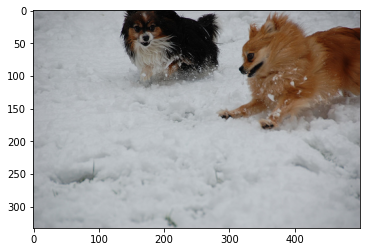

Greedy: two dogs running in the snow
Beam: brown and white dog is walking in the snow


In [65]:
pic = '2398605966_1d0c9e6a20.jpg'
images_path = '/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/'

encoded_image = test_features[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_image))
print("Beam:",beam_search_predictions(encoded_image,5))

In [54]:
test_images_file = '/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr_8k.testImages.txt'
test_image_file = open(test_images_file, 'r').read().strip().split('\n')

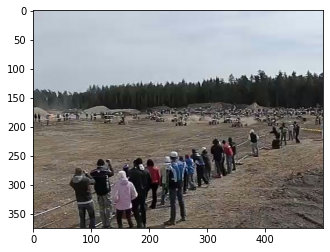

Greedy: many people are walking in the mountains of lake covered
Beam: group of people are running in the people on the mountains





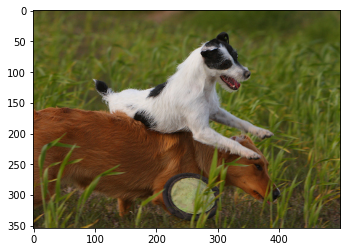

Greedy: white dog is brown with brown and white dog
Beam: brown and white dog is running on grass





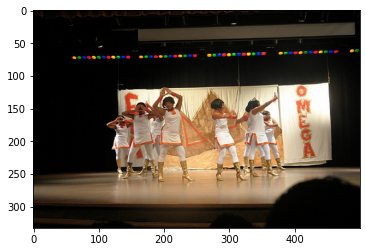

Greedy: group of girls are standing onstage in an outdoor
Beam: group of women are dancing in costumes





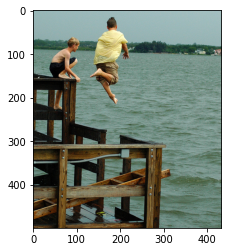

Greedy: woman in bikini is sitting on boardwalk near the water out
Beam: woman sits on the shore at





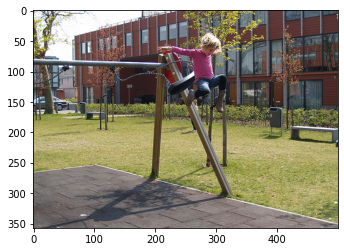

Greedy: man is doing on rail
Beam: man in white shirt is black on the top





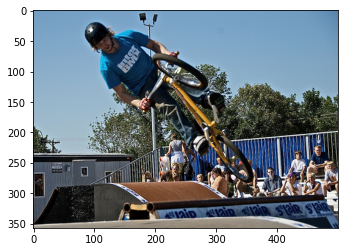

Greedy: man is doing trick on his skateboard
Beam: the man is in the bike





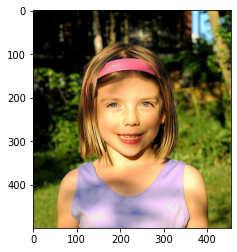

Greedy: young girl with brown hair hair hair
Beam: little girl with brown hair hair hair and in in yellow





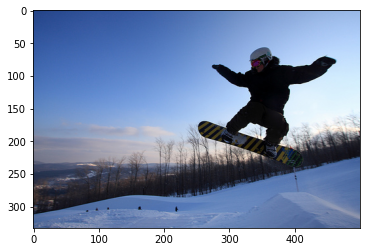

Greedy: snowboarder in red pants is white jacket is jumping on the snowy
Beam: the man is in the the down down mountain down down machine machine machine machine machine on blue top in pink jacket jacket jacket striped striped striped striped striped striped jacket standing in





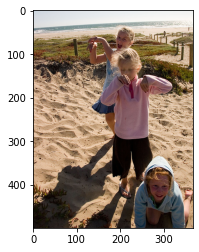

Greedy: boy boy wearing hat shirt on the sand of the water
Beam: little boy is standing in water on the sand in the in the ocean





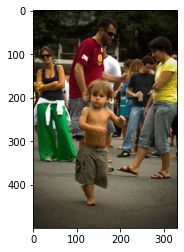

Greedy: group of children are playing on paved road of watching
Beam: group of children are playing on sidewalk





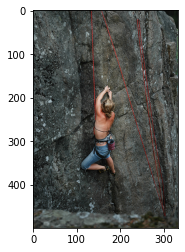

Greedy: man climbs up rock face
Beam: man is climbing climbing wall wall the rocky rocky rocky rocky





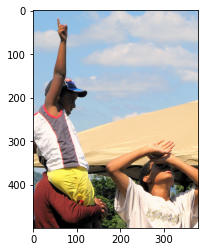

Greedy: woman in bathing safety is using on deck lounge
Beam: woman with black and is in an





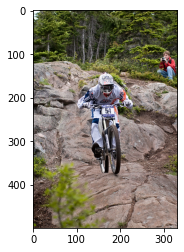

Greedy: man in blue uniform uniform his bike bike through the dirt
Beam: man is riding on dirt bike hill hill hill hill hill hill hill hill





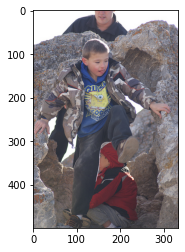

Greedy: man in blue shirt climbing rock
Beam: man is rock climbing rocky





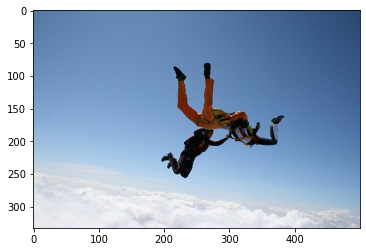

Greedy: man in green shirt is performing to the air on the sand
Beam: the man is in the air in the air





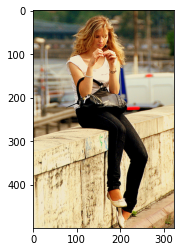

Greedy: the girl is jumping on stone
Beam: the girl is standing on skateboard wall wall to her to the arm to to to face





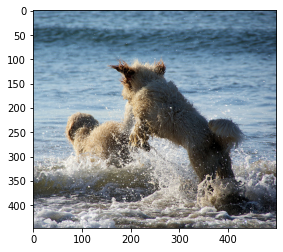

Greedy: white dog runs along the beach
Beam: white dog runs on the beach





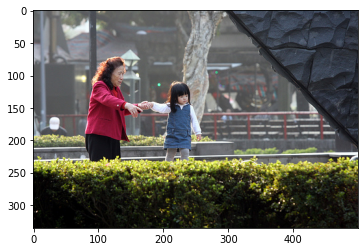

Greedy: girl in pink shirt and blue jeans is on the sidewalk
Beam: the little girl is pink on the trampoline on stone





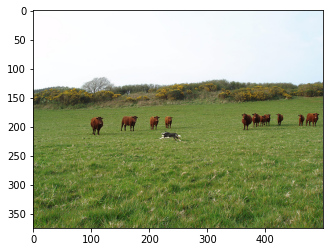

Greedy: pack of dogs are pulling huge through some grass
Beam: dogs of dogs are standing on trail





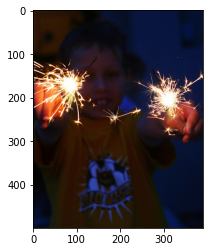

Greedy: two children are in the sky of yellow
Beam: the boy boy is yellow the blue white blue blue yellow blue boat boat the the boat the the boat the the boat boat boat boat hold hold hold hold hold hold hold





In [55]:
for pic in test_image_file[70:90]: 
  encoded_image = test_features[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(encoded_image))
  print("Beam:",beam_search_predictions(encoded_image,5))
  print("\n\n")

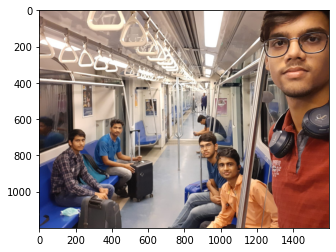

Greedy: two men sit in front of an office african village
Beam: man is woman sit sit in carnival in front paper paper


In [69]:
path = '/content/drive/MyDrive/ImageCaptioning/27493fbf-505b-44f7-82a0-0e33c1de056f.jpg'

encoded_images = encode(path).reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_images))
print("Beam:",beam_search_predictions(encoded_images,5))

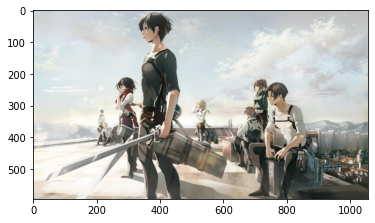

Greedy: man is pulling down railing of some
Beam: group of young boys are are in one are in the building in in in in


In [70]:
path = '/content/drive/MyDrive/ImageCaptioning/cropped-1920-1080-612522.jpg'

encoded_images = encode(path).reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_images))
print("Beam:",beam_search_predictions(encoded_images,5))